<a href="https://colab.research.google.com/github/SimoneGiaco/Portfolio/blob/main/PINN/PINN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PINN model trained on T4 GPU**

### Model Architecture

In [7]:
#Required libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline

In [8]:
#Simple PINN architecture to solve the ODE y''=-(\pi/5)^2*y. The solution y is given by the output of the neural network
class ODE2(nn.Module):
    def __init__(self, in_d, layer):
        super(ODE2,self).__init__()
        self.nlp=nn.Sequential(
            nn.Linear(in_d, layer),
            nn.Tanh(),
            nn.Linear(layer, layer),
            nn.Tanh(),
            nn.Linear(layer, layer),
            nn.Tanh(),
            nn.Linear(layer, layer),
            nn.Tanh(),
            nn.Linear(layer, in_d)
        )

    def forward(self,x):
        return self.nlp(x)

### Training settings and plotting function

In [9]:
#Setting for the training. We impose the boundary conditions at 0 (point1) and we choose for the training a grid of 200 points in the interval [0,20]
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(23)
trial= ODE2(1,30).to(device)

data=torch.linspace(0,20,200).view(200,-1).requires_grad_(True).to(device)

point1=torch.Tensor([0]).reshape(1,1).requires_grad_(True).to(device)

In [10]:
#Function for plotting the analytic and numeric solutions in the range [0,33.3].
#We want to impose boundary condition y(0)=const and for convenience we set y=const + trial so that trial (the PINN output) is0 at 0
def plot_graph(trial, const):
    domain=torch.arange(1000)/30
    domain=domain.reshape(1000,-1).to(device)
    numeric=[x.item() for x in const+trial(domain)]  #numeric approximation returned by the PINN network
    f_an=2*torch.cos(np.pi*domain/5) #analytic formula for const=2 (we will use this value below)
    analytic=[x.item() for x in f_an]

    plt.plot(numeric, label='Numeric', color='b')
    plt.plot(analytic, label='Analytic', color='r')
    plt.legend()
    plt.show()

### Training loop

Epoch 0, Loss 0.013814851641654968


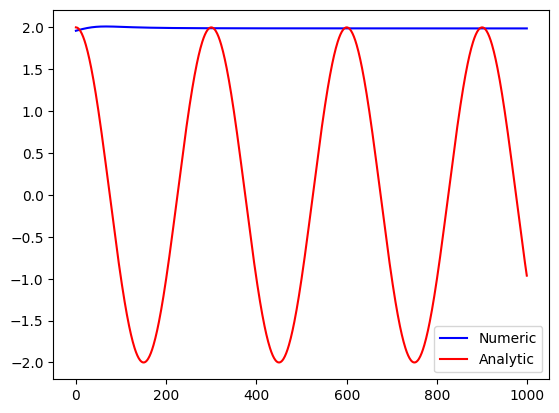

Epoch 3000, Loss 4.221825292916037e-05
Epoch 6000, Loss 3.540081161190756e-05
Epoch 9000, Loss 4.3953536078333855e-05
Epoch 12000, Loss 2.5645042114774697e-05
Epoch 15000, Loss 1.9425220671109855e-05
Epoch 18000, Loss 1.9560384316719137e-05
Epoch 21000, Loss 1.7747941456036642e-05
Epoch 24000, Loss 1.8794564311974682e-05
Epoch 27000, Loss 1.6555723050259985e-05
Epoch 30000, Loss 1.5395626178360544e-05
Epoch 33000, Loss 1.5346908185165375e-05
Epoch 36000, Loss 1.348644946119748e-05
Epoch 39000, Loss 1.1482579793664627e-05
Epoch 42000, Loss 6.969337118789554e-05
Epoch 45000, Loss 1.2869485544797499e-05
Epoch 48000, Loss 1.33225594254327e-05


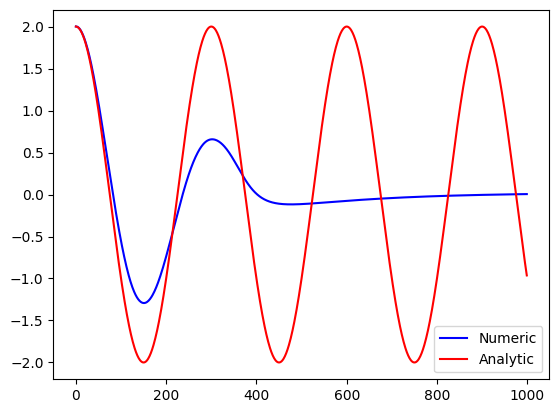

Epoch 51000, Loss 1.765685919963289e-05
Epoch 54000, Loss 1.4127310350886546e-05
Epoch 57000, Loss 3.171131538692862e-05
Epoch 60000, Loss 2.507532190065831e-05
Epoch 63000, Loss 2.1254323655739427e-05
Epoch 66000, Loss 1.5368996173492633e-05
Epoch 69000, Loss 1.4359331544255838e-05
Epoch 72000, Loss 1.2816111848223954e-05
Epoch 75000, Loss 1.1784976777562406e-05
Epoch 78000, Loss 1.0400905011920258e-05
Epoch 81000, Loss 1.0624994501995388e-05
Epoch 84000, Loss 8.798905582807492e-06
Epoch 87000, Loss 6.7128157752449624e-06
Epoch 90000, Loss 4.691360118158627e-06
Epoch 93000, Loss 4.812128281628247e-06
Epoch 96000, Loss 4.565322797134286e-06
Epoch 99000, Loss 3.191851419614977e-06


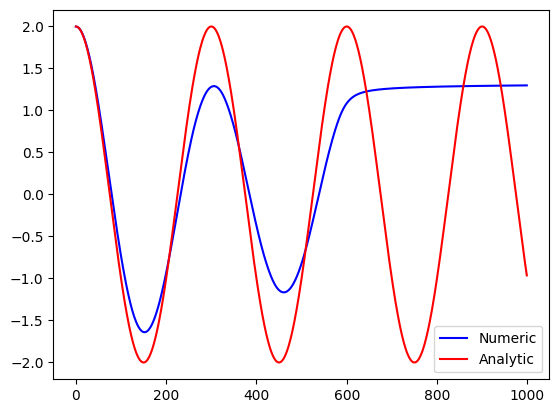

Epoch 102000, Loss 8.197242095775437e-06
Epoch 105000, Loss 2.8568049401656026e-06
Epoch 108000, Loss 2.1112557533342624e-06
Epoch 111000, Loss 3.1323422717832727e-06
Epoch 114000, Loss 2.0091260921617504e-06
Epoch 117000, Loss 1.4728958603882347e-06
Epoch 120000, Loss 1.3008482255827403e-06
Epoch 123000, Loss 4.740558665616845e-07
Epoch 126000, Loss 1.459319491914357e-06
Epoch 129000, Loss 2.1836160613020184e-07
Epoch 132000, Loss 1.0775379877259184e-07
Epoch 135000, Loss 2.0107511033984338e-07
Epoch 138000, Loss 8.495275238828981e-08
Epoch 141000, Loss 1.6133449776134512e-07
Epoch 144000, Loss 2.3723741193748538e-08
Epoch 147000, Loss 7.76033388660835e-08
Epoch 150000, Loss 8.987893096445987e-08


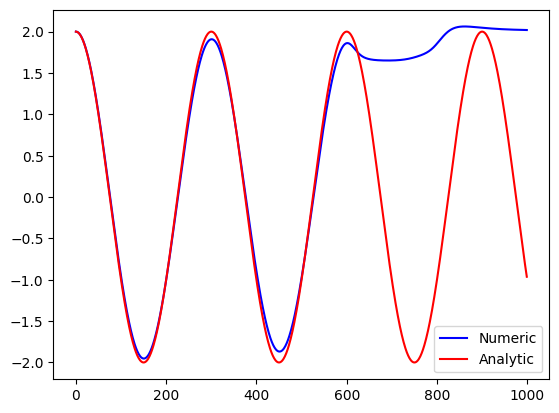

Epoch 153000, Loss 4.4775585905654225e-08
Epoch 156000, Loss 4.128442654405262e-08
Epoch 159000, Loss 2.326118853090975e-08


In [11]:
# In the loss function we add the boundary conditions y(0)=2 and y'(0)=0
# The settings for the training have been found starting from those of known PINNs and optimizing for the problem at hand
# We plot the graphs of exact and numeric solutions every 50000 epochs
optimizer=optim.Adam(trial.parameters(), lr=0.0015, betas=(0.9, 0.999))

epochs=160000
const=torch.tensor(2.0).to(device)
error=[] #list in which we store the value of the loss after each epoch
for i in range(epochs):
    der=torch.autograd.grad(trial(point1), point1, torch.ones_like(trial(point1)), create_graph=True)[0].to(device) #compute derivative of trial at 0
    optimizer.zero_grad()
    y=const+trial(data)
    der1=torch.autograd.grad(y.reshape(-1,1), data, torch.ones_like(y), create_graph=True)[0].to(device) #derivative of trial in the domain [0,20]
    der2=torch.autograd.grad(der1, data, torch.ones_like(der1), create_graph=True)[0].to(device) #second derivative of trial in the domain [0,20]

    #Loss function is the sum of 3 terms. The first imposes validity of the equation. The other two impose the boundary conditions
    loss=0.001*nn.MSELoss()(torch.flatten(der2), -(np.pi**2/25)*torch.flatten(y))+1*(trial(point1))**2+1*(der)**2
    error.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(trial.parameters(), max_norm=0.1, norm_type=2.0, error_if_nonfinite=False) #we clip the gradients for better convergence
    optimizer.step()
    if i%3000==0:
        print(f"Epoch {i}, Loss {error[-1]}")
    if i%50000==0:
        plot_graph(trial, const)


### Plotting the final result

Numeric vs analytic solutions

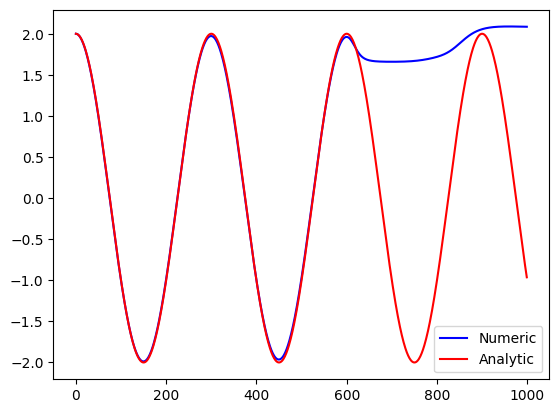

In [12]:
#We plot the analytic and trained numeric solutions in the range [0,33.3]. In the training range [0,20] the two essentially coincide
plot_graph(trial, const)

Comparison between analytic and numeric second derivatives

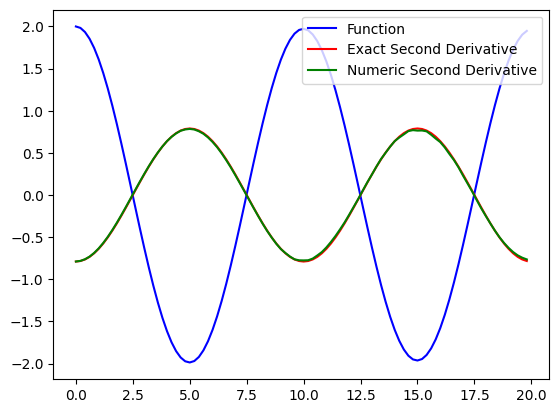

In [22]:
#We plot in the dotraining domain [0,20] the analytic function, its second derivative and the second derivative of the numeric solution.
a=(torch.arange(100)/5).view(-1,1).requires_grad_(True).to(device)
y=const+trial(a)
f_an=2*torch.cos(np.pi*a/5).detach()
der2_an=[x.item() for x in -(np.pi**2/25)*f_an]
der1=[torch.autograd.grad(outputs=out, inputs=a, retain_graph=True, create_graph=True)[0][i] for i, out in enumerate(y.reshape(-1,1))]
der2=[torch.autograd.grad(outputs=out, inputs=a, retain_graph=True)[0][i] for i, out in enumerate(der1)]
der2_num=[x.item() for x in der2]

plt.plot(a.detach().cpu().numpy(),y.detach().cpu().numpy(), label='Function', color='b')
plt.plot(a.detach().cpu().numpy(),der2_an, label='Exact Second Derivative', color='r')
plt.plot(a.detach().cpu().numpy(),der2_num, label='Numeric Second Derivative', color='g')
plt.legend()
plt.show()